<a href="https://colab.research.google.com/github/bhanujgunas/quantumautoencoder/blob/main/ibm_torino_qautoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Package installation and dataset downloading

In [ ]:
# Single-Threaded Downloading
!curl -L -o cbis-ddsm.zip https://www.kaggle.com/api/v1/datasets/download/awsaf49/cbis-ddsm-breast-cancer-image-dataset
!unzip -q cbis-ddsm.zip -d CBIS_DDSM


In [1]:
# Multi-Threaded Downloading for fast downloading

!apt install aria2 -y
!aria2c -x 16 -s 16 -k 2M "https://www.kaggle.com/api/v1/datasets/download/awsaf49/cbis-ddsm-breast-cancer-image-dataset" -o cbis-ddsm.zip
!unzip -q cbis-ddsm.zip -d CBIS_DDSM


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 2 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 1s (1,195 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubunt

In [2]:
!pip install torch torchvision torchaudio
!pip install qiskit qiskit-ibm-runtime qiskit-machine-learning
!pip install opencv-python pandas scikit-learn tqdm
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9

2. Import Test

In [3]:
import torch, cv2, qiskit
from qiskit_ibm_runtime import QiskitRuntimeService

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("OpenCV:", cv2.__version__)
print("Qiskit:", qiskit.__version__)


Torch: 2.9.0+cpu
CUDA available: False
OpenCV: 4.13.0
Qiskit: 2.3.0


3. IBM Credential Saving

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator

QiskitRuntimeService.save_account(
token="rYvbFeN2vWCyjuPArD5bMNXzwsasrzaTgQOwpUFkJrUd", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
instance="qautoencoder", # Optional - instance
overwrite=True)

service = QiskitRuntimeService()
print(service.backends())
backend = service.backend("ibm_torino")
print("Backend:", backend.name)


[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]
Backend: ibm_torino


4. Imports & Environment

In [5]:
import os, glob, cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session


5. Global Configuration

In [6]:
ROOT_DIR = "/content/CBIS_DDSM"
IMAGE_SIZE = 256
BATCH_SIZE = 2
EPOCHS = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [7]:
metadata = pd.read_csv(f"{ROOT_DIR}/csv/meta.csv")
dicom = pd.read_csv(f"{ROOT_DIR}/csv/dicom_info.csv")

mass_train = pd.read_csv(f"{ROOT_DIR}/csv/mass_case_description_train_set.csv")
mass_test  = pd.read_csv(f"{ROOT_DIR}/csv/mass_case_description_test_set.csv")

calc_train = pd.read_csv(f"{ROOT_DIR}/csv/calc_case_description_train_set.csv")
calc_test  = pd.read_csv(f"{ROOT_DIR}/csv/calc_case_description_test_set.csv")

print("Metadata:",metadata.shape)
print("Dicom:",dicom.shape)
print("Mass train:", mass_train.shape)
print("Mass test:", mass_test.shape)
print("Calc train:", calc_train.shape)
print("Calc test:", calc_test.shape)


Metadata: (6775, 9)
Dicom: (10237, 38)
Mass train: (1318, 14)
Mass test: (378, 14)
Calc train: (1546, 14)
Calc test: (326, 14)


In [8]:
def prepare_df_mass_train(df):
    df = df.copy()

    # pathology label
    df["pathology_final"] = df["pathology"].map({
        "BENIGN": 0,
        "BENIGN_WITHOUT_CALLBACK": 0,
        "MALIGNANT": 1
    })

    # keep only what we need
    keep_cols = [
        "patient_id",
        #"breast_density",
        "left or right breast",
        "image view",
        #"abnormality id",
        #"abnormality type",
        #"mass shape",
        #"mass margins",
        #"assessment",
        #"pathology",
        #"subtlety",
        "image file path",
        "cropped image file path",
        "ROI mask file path",
        "pathology_final"
    ]
    return df[keep_cols]

df_mass_train = pd.concat([
    prepare_df_mass_train(mass_train),
    # prepare_df(mass_test, "mass")
], ignore_index=True)

#df = df.dropna(subset=["label"])
print("Total samples:", len(df_mass_train))
df_mass_train.head()


Total samples: 1318


,patient_id,left or right breast,image view,image file path,cropped image file path,ROI mask file path,pathology_final
0,P_00001,LEFT,CC,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,1
1,P_00001,LEFT,MLO,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,1
2,P_00004,LEFT,CC,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,0
3,P_00004,LEFT,MLO,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,0
4,P_00004,RIGHT,MLO,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,0


In [9]:
def prepare_df_meta(df):
    df = df.copy()

    # keep only what we need
    keep_cols = [
        "SeriesInstanceUID",
        "StudyInstanceUID",
        #"Modality",
        "SeriesDescription",
        "ImageCount"
    ]
    return df[keep_cols]

df_meta = pd.concat([
    prepare_df_meta(metadata),
], ignore_index=True)

#df = df.dropna(subset=["label"])
print("Total samples:", len(df_meta))
df_meta.head()

Total samples: 6775


,SeriesInstanceUID,StudyInstanceUID,SeriesDescription,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,ROI mask images,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,ROI mask images,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,ROI mask images,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,ROI mask images,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,ROI mask images,2


In [10]:
def prepare_df_dicom(df):
    df = df.copy()
    df.head()
    # keep only what we need

    keep_cols = [
        "file_path",
        "image_path",
        #"BitsAllocated",
        #"BitsStored",
        "BodyPartExamined",
        #"Columns",
        #"ContentDate",
        #"ContentTime",
        #"ConversionType",
        #"HighBit",
        #"LargestImagePixelValue",
        "Laterality",
        #"Modality",
        "PatientID",
        "PatientName",
        "PatientOrientation",
        #"Rows",
        #"SOPClassUID",
        "SOPInstanceUID",
        "SeriesDescription",
        "SeriesInstanceUID",
        #"SmallestImagePixelValue",
        #"StudyDate",
        "StudyInstanceUID",
        #"StudyTime"
    ]
    return df[keep_cols]

df_dicom = pd.concat([
    prepare_df_dicom(dicom),
], ignore_index=True)

print("Total samples:", len(df_dicom))
df_dicom.head(10)

Total samples: 10237


,file_path,image_path,BodyPartExamined,Laterality,PatientID,PatientName,PatientOrientation,SOPInstanceUID,SeriesDescription,SeriesInstanceUID,StudyInstanceUID
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,BREAST,R,Mass-Training_P_01265_RIGHT_MLO_1,Mass-Training_P_01265_RIGHT_MLO_1,MLO,1.3.6.1.4.1.9590.100.1.2.426380754911844882201...,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,BREAST,R,Mass-Training_P_01754_RIGHT_CC,Mass-Training_P_01754_RIGHT_CC,CC,1.3.6.1.4.1.9590.100.1.2.235715018911442345533...,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,BREAST,R,Calc-Training_P_00232_RIGHT_CC,Calc-Training_P_00232_RIGHT_CC,CC,1.3.6.1.4.1.9590.100.1.2.212917405611495375422...,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,BREAST,L,Calc-Test_P_00562_LEFT_CC_2,Calc-Test_P_00562_LEFT_CC_2,CC,1.3.6.1.4.1.9590.100.1.2.405776661412249467913...,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,Left Breast,NaN,P_00562_LEFT_CC_2.dcm,P_00562^P_00562,CC,1.3.6.1.4.1.9590.100.1.2.418434643810489919922...,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...
5,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.15333...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...,BREAST,R,Calc-Training_P_00181_RIGHT_CC_1,Calc-Training_P_00181_RIGHT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.265034136111320280631...,ROI mask images,1.3.6.1.4.1.9590.100.1.2.153339052913121382622...,1.3.6.1.4.1.9590.100.1.2.157384031212566921514...
6,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.15333...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...,BREAST,R,Calc-Training_P_00181_RIGHT_CC_1,Calc-Training_P_00181_RIGHT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.398771175312365272736...,cropped images,1.3.6.1.4.1.9590.100.1.2.153339052913121382622...,1.3.6.1.4.1.9590.100.1.2.157384031212566921514...
7,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.17899...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...,BREAST,L,Calc-Training_P_01015_LEFT_CC_1,Calc-Training_P_01015_LEFT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.131386567811700111319...,cropped images,1.3.6.1.4.1.9590.100.1.2.178994714611485132105...,1.3.6.1.4.1.9590.100.1.2.250103550412831547020...
8,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.17899...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...,BREAST,L,Calc-Training_P_01015_LEFT_CC_1,Calc-Training_P_01015_LEFT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.294915843610022454741...,ROI mask images,1.3.6.1.4.1.9590.100.1.2.178994714611485132105...,1.3.6.1.4.1.9590.100.1.2.250103550412831547020...
9,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.41183...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...,BREAST,L,Calc-Training_P_01497_LEFT_CC_1,Calc-Training_P_01497_LEFT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.318779025102243592402...,ROI mask images,1.3.6.1.4.1.9590.100.1.2.411833492612373627114...,1.3.6.1.4.1.9590.100.1.2.407544576612957992910...


Cropped Image: 3567
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object


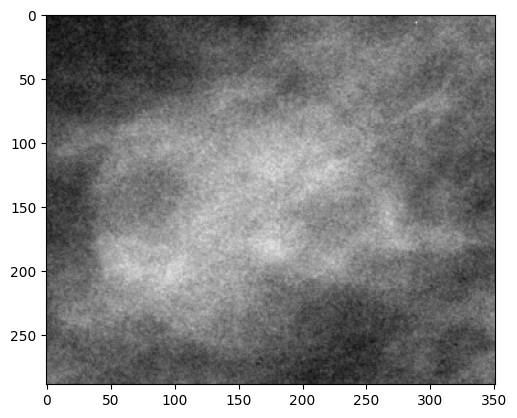

In [11]:
cropped_images=df_dicom[df_dicom.SeriesDescription == 'cropped images'].image_path
print("Cropped Image:",len(cropped_images))
print(cropped_images[0])
print(cropped_images.head())
cropped_img_show = PIL.Image.open(ROOT_DIR+cropped_images[0].strip("CBIS-DDSM"))
gray_img= cropped_img_show.convert("L")
plt.imshow(cropped_img_show, cmap='gray')


Full Mammography Image: 2857
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object


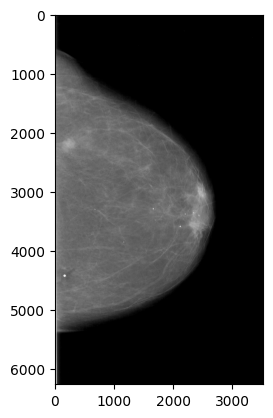

In [12]:
full_mammography_images=df_dicom[df_dicom.SeriesDescription == 'full mammogram images'].image_path
print("Full Mammography Image:",len(full_mammography_images))
print(full_mammography_images[1])
print(full_mammography_images.head())
full_img_show = PIL.Image.open(ROOT_DIR+full_mammography_images[1].strip("CBIS-DDSM"))
gray_img= full_img_show.convert("L")
plt.imshow(gray_img, cmap='gray')

ROI Mask Image: 3247
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg
5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object


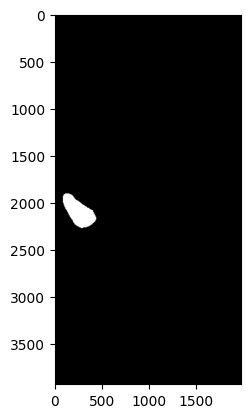

In [13]:
roi_mask_images=df_dicom[df_dicom.SeriesDescription == 'ROI mask images'].image_path
print("ROI Mask Image:",len(roi_mask_images))
print(roi_mask_images[5])
print(roi_mask_images.head())
roi_mask_show = PIL.Image.open(ROOT_DIR+roi_mask_images[5].strip("CBIS-DDSM"))
gray_img= roi_mask_show.convert("L")
plt.imshow(gray_img, cmap='gray')

In [14]:
r= pd.DataFrame(dicom['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

,SeriesDescription_counts,count
0,cropped images,3567
1,ROI mask images,3247
2,full mammogram images,2857


In [15]:
q= pd.DataFrame(dicom['PatientOrientation'].value_counts())
q= q.reset_index()
q= q.rename(columns={'PatientOrientation':'PatientOrientation_counts', 'index':'PatientOrientation'})
q

,PatientOrientation_counts,count
0,MLO,5434
1,CC,4803


In [16]:
f= pd.DataFrame(dicom['BodyPartExamined'].value_counts())
f= f.reset_index()
f= f.rename(columns={'BodyPartExamined':'BodyPartExamined_counts', 'index':'Breast part Examined'})
f

,BodyPartExamined_counts,count
0,BREAST,9671
1,Left Breast,318
2,Right Breast,248


In [17]:
full_mammography_dict = dict(map(lambda x: (x.split('/')[2], "/".join([ROOT_DIR]+x.split('/')[1:])), full_mammography_images))
cropped_dict = dict(map(lambda x: (x.split('/')[2], "/".join([ROOT_DIR]+x.split('/')[1:])), cropped_images))
roi_mask_dict = dict(map(lambda x: (x.split('/')[2], "/".join([ROOT_DIR]+x.split('/')[1:])), roi_mask_images))
print("Full Mammography : ", len(full_mammography_dict))
print("Cropped : ", len(cropped_dict))
print("ROI Mask : ", len(roi_mask_dict))

from collections import Counter
import cv2

size_count = Counter()

for k in cropped_dict:
    img = cv2.imread(cropped_dict[k])
    if img is None:
        continue  # safety check

    shape = img.shape  # keep as tuple, not string
    size_count[shape] += 1

# sort by frequency (descending)
sorted_size = dict(
    sorted(size_count.items(), key=lambda x: x[1], reverse=True)
)

print(sorted_size)

Full Mammography :  2857
Cropped :  3567
ROI Mask :  3247
{(129, 113, 3): 11, (137, 129, 3): 9, (129, 129, 3): 8, (169, 185, 3): 8, (145, 145, 3): 8, (129, 153, 3): 7, (89, 105, 3): 7, (185, 201, 3): 6, (201, 193, 3): 6, (217, 217, 3): 6, (185, 209, 3): 6, (193, 217, 3): 6, (137, 153, 3): 6, (121, 113, 3): 6, (137, 137, 3): 6, (137, 113, 3): 6, (97, 97, 3): 5, (121, 137, 3): 5, (153, 137, 3): 5, (113, 89, 3): 5, (169, 153, 3): 5, (137, 121, 3): 5, (129, 105, 3): 5, (145, 161, 3): 5, (153, 161, 3): 5, (153, 185, 3): 5, (113, 129, 3): 5, (177, 209, 3): 5, (121, 105, 3): 5, (193, 209, 3): 5, (161, 145, 3): 5, (193, 193, 3): 5, (209, 209, 3): 5, (113, 105, 3): 5, (89, 81, 3): 4, (81, 81, 3): 4, (161, 137, 3): 4, (161, 129, 3): 4, (185, 185, 3): 4, (201, 177, 3): 4, (257, 249, 3): 4, (161, 185, 3): 4, (225, 217, 3): 4, (97, 121, 3): 4, (121, 121, 3): 4, (89, 89, 3): 4, (217, 169, 3): 4, (233, 201, 3): 4, (97, 105, 3): 4, (105, 97, 3): 4, (217, 233, 3): 4, (217, 209, 3): 4, (185, 217, 3): 4,

In [18]:
from torchvision import transforms
from PIL import Image

# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure grayscale
    transforms.Resize((64, 64)),                   # resize to 64x64
    transforms.ToTensor(),                         # (1, 64, 64), values in [0,1]
])

# Example usage
img = Image.open(cropped_dict['1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132'])   # any size image
img_tensor = transform(img)     # shape: (1, 64, 64)

print(img_tensor.shape)


torch.Size([1, 64, 64])


In [19]:
import os
cropped_image_list = list(cropped_dict.values())
os.mkdir("/content/cropped_images")
for i in range(len(cropped_image_list)):
    os.system(f"cp {cropped_image_list[i]} /content/cropped_images")

In [29]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CroppedDataset(Dataset):
    def __init__(self, cropped_dict, transform=None):
        self.image_paths = list(cropped_dict.values())
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img


from torch.utils.data import DataLoader

dataset = CroppedDataset(cropped_dict, transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True
)

In [30]:
# Get one batch of real cropped images
images = next(iter(dataloader))   # shape: (B, 1, 64, 64)

print("Batch shape:", images.shape)


Batch shape: torch.Size([16, 1, 64, 64])


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(64 * 8 * 8, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        z = self.fc(x)
        return z

        # Input        : (B, 1, 64, 64)
        # Conv1 + Pool : (B, 16, 32, 32)
        # Conv2 + Pool : (B, 32, 16, 16)
        # Conv3 + Pool : (B, 64, 8, 8)
        # Flatten      : 4096
        # Latent z     : (B, 8)



In [35]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
encoder = Encoder(latent_dim=4).to(device=DEVICE)  # 4 or 8

# Dummy input
# x = torch.randn(1, 1, 64, 64)
images = images.to(DEVICE)

# Forward pass
z = encoder(images)

print("Latent vector shape:", z.shape)


Latent vector shape: torch.Size([16, 4])


In [36]:
encoder.eval()


Encoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=4, bias=True)
)

In [37]:
images = next(iter(dataloader))
images = images.to(DEVICE)

with torch.no_grad():
    z = encoder(images)

print("Input batch:", images.shape)
print("Latent batch:", z.shape)
print("First latent vector:", z[0])

Input batch: torch.Size([16, 1, 64, 64])
Latent batch: torch.Size([16, 4])
First latent vector: tensor([ 0.0043,  0.0432, -0.0151,  0.0012])


In [38]:
import pennylane as qml
import torch
import torch.nn as nn

def variational_block(weights, wires):
    for i, w in enumerate(wires):
        qml.RY(weights[i, 0], wires=w)
        qml.RZ(weights[i, 1], wires=w)

    # Entanglement
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])


In [39]:
class QuantumAutoencoder(nn.Module):
    def __init__(self, n_qubits=4, n_bottleneck=2):
        super().__init__()

        self.n_qubits = n_qubits
        self.n_bottleneck = n_bottleneck

        self.dev = qml.device("default.qubit", wires=n_qubits)
        #self.dev = qml.device("lightning.qubit", wires=n_qubits)

        self.weights = nn.Parameter(
            0.01 * torch.randn(n_qubits, 2)
        )

        @qml.qnode(self.dev, interface="torch")
        def circuit(z, weights):
            # 1️⃣ Embed classical latent vector
            qml.AngleEmbedding(z, wires=range(n_qubits))

            # 2️⃣ Encoder (compression)
            variational_block(weights, wires=range(n_qubits))

            # 🚫 NO RESET HERE
            # Bottleneck is implicit: only some qubits carry info

            # 3️⃣ Decoder (inverse unitary)
            qml.adjoint(variational_block)(weights, wires=range(n_qubits))

            # 4️⃣ Reconstruct latent vector
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        self.circuit = circuit

    def forward(self, z):
      outputs = []
      for i in range(z.shape[0]):
          out = self.circuit(z[i], self.weights)
          out = torch.stack(out)      # 👈 FIX HERE
          outputs.append(out)
      return torch.stack(outputs)

In [41]:
# Example latent vector from CNN encoder
batch_size = 2
latent_dim = 4

z = torch.randn(batch_size, latent_dim)

qae = QuantumAutoencoder(
    n_qubits=latent_dim,
    n_bottleneck=2
)

z_recon = qae(z)

print("Input z shape:", z.shape)
print("Reconstructed z shape:", z_recon.shape)



Input z shape: torch.Size([2, 4])
Reconstructed z shape: torch.Size([2, 4])


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()

        # 4 → 4096
        self.fc = nn.Linear(latent_dim, 64 * 8 * 8)

        # Upsampling layers
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 8→16
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 16→32
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2)   # 32→64

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 64, 8, 8)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))

        return x


In [43]:
decoder = Decoder(latent_dim=4).to(DEVICE)
z_sample = torch.randn(2, 4).to(DEVICE)
x_recon = decoder(z_sample)

print(x_recon.shape)


torch.Size([2, 1, 64, 64])


In [45]:
images = next(iter(dataloader))
images = images.to(DEVICE)

# Encode
z = encoder(images)

# Normalize for quantum
z_norm = z / (z.abs().max(dim=1, keepdim=True)[0] + 1e-8)
z_norm = z_norm * torch.pi

# Quantum
z_recon = qae(z_norm)

# Decode
z_recon = z_recon.float()   # convert to float32
reconstructed = decoder(z_recon.to(DEVICE))

print("Input:", images.shape)
print("Reconstructed:", reconstructed.shape)


Input: torch.Size([16, 1, 64, 64])
Reconstructed: torch.Size([16, 1, 64, 64])


In [46]:
class HybridAutoencoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()

        self.encoder = Encoder(latent_dim)
        self.quantum = QuantumAutoencoder(n_qubits=latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        # 1️⃣ Encode image → latent vector
        z = self.encoder(x)

        # 2️⃣ Normalize for quantum stability
        z_norm = z / (z.abs().max(dim=1, keepdim=True)[0] + 1e-8)
        z_norm = z_norm * torch.pi

        # 3️⃣ Quantum autoencoder
        z_recon = self.quantum(z_norm)

        # 4️⃣ Convert dtype (important fix)
        z_recon = z_recon.float()

        # 5️⃣ Decode back to image
        x_recon = self.decoder(z_recon)

        return x_recon


In [47]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridAutoencoder(latent_dim=4).to(DEVICE)

print(model)


HybridAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=4096, out_features=4, bias=True)
  )
  (quantum): QuantumAutoencoder()
  (decoder): Decoder(
    (fc): Linear(in_features=4, out_features=4096, bias=True)
    (deconv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (deconv2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (deconv3): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)


In [48]:
images = next(iter(dataloader))
images = images.to(DEVICE)

reconstructed = model(images)

print("Input shape:", images.shape)
print("Reconstructed shape:", reconstructed.shape)


Input shape: torch.Size([16, 1, 64, 64])
Reconstructed shape: torch.Size([16, 1, 64, 64])


In [49]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0

    for images in dataloader:
        images = images.to(DEVICE)

        optimizer.zero_grad()

        reconstructed = model(images)

        loss = criterion(reconstructed, images)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1, Loss: 0.0261
Epoch 2, Loss: 0.0123
Epoch 3, Loss: 0.0119
Epoch 4, Loss: 0.0117
Epoch 5, Loss: 0.0117


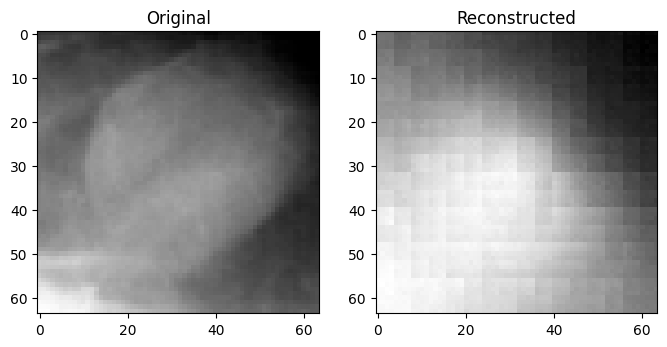

In [54]:
import matplotlib.pyplot as plt

images = next(iter(dataloader)).to(DEVICE)
recon = model(images)

img = images[2].detach().cpu().squeeze()
rec = recon[2].detach().cpu().squeeze()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(rec, cmap='gray')
plt.show()


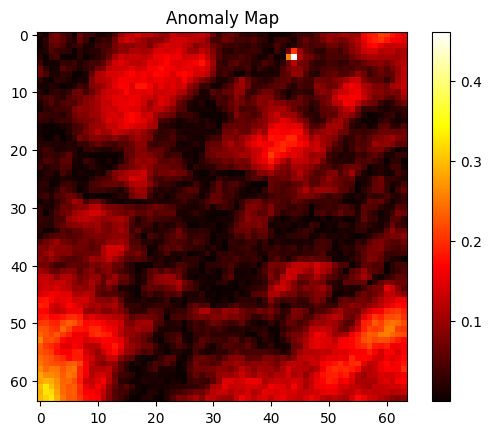

In [55]:
error_map = torch.abs(images - recon)

heatmap = error_map[0].detach().cpu().squeeze()

plt.imshow(heatmap, cmap='hot')
plt.title("Anomaly Map")
plt.colorbar()
plt.show()


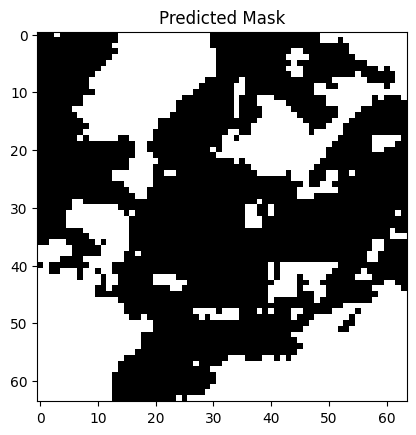

In [56]:
threshold = heatmap.mean()
binary_mask = heatmap > threshold

plt.imshow(binary_mask, cmap='gray')
plt.title("Predicted Mask")
plt.show()


In [ ]:
def dice_score(pred, target):
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)
